In [1]:
import sys
sys.path.append('/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github')


In [ ]:

# import pysparnn.cluster_index as ci
# import scipy.sparse
# import os
# import math
import numpy as np
import pandas as pd
import random
from utils import train_test_split, df_to_matrix ,matrix_to_df_2, threshold_interactions_df, matrix_to_df,set_intersection,get_0_and_p_index,set_diff, matrix_to_full_df

!pip install surprise
from surprise import Reader, accuracy
from surprise import SVD
from surprise import Dataset
from collections import Counter
from collections import defaultdict

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from pct.tree.heuristic.Heuristic import Heuristic5
from pct.tree.heuristic.NumericHeuristic_movie import NumericHeuristic5
from pct.tree.splitter.splitter import Splitter
from pct.tree.tree import Tree


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
data = pd.read_csv("ml-1m/ratings.txt",sep='::',index_col=False,names=["user_id","item_id","rating","timestamp"],header=None,engine='python')
my_seed = 7
random.seed(my_seed)
np.random.seed(my_seed)
# Iteratively filters out users and items with fewer than the threshold number of interactions until no changes happen.
data = threshold_interactions_df(data,'user_id','item_id',100,100)
matrix,rid_to_idx, idx_to_rid, cid_to_idx, idx_to_cid = df_to_matrix(data,"user_id","item_id","rating")

# split to train, X and eval sets
al,train,_ = train_test_split(matrix,1) # train_test_split(interactions, split_count, fraction=None)
# train: a matrix containing only the 1 held-out rating per user

# ml 1M
X_matrix,test,_ = train_test_split(al,30)
# test: a matrix containing only the 30 held-out ratings per user
# X: a matrix containing the rest of the ratings

Starting interactions info
Number of rows: 6040
Number of cols: 3706
Sparsity: 4.468%
Ending interactions info
Number of rows: 2828
Number of columns: 1919
Sparsity: 14.284%


In [4]:
def get_nodes_by_level(self, level):
    """
    Retrieve all nodes at a specific level with valid item IDs and their associated users.
    
    :param level: The depth level (0-indexed)
    :return: List of tuples (node, user_ids) where:
             - node.attribute_name is a valid integer item ID
             - user_ids is list of original user IDs in this node
    """
    if self.root is None:
        return []

    queue = [(self.root, 0)]
    valid_nodes = []

    while queue:
        node, current_level = queue.pop(0)

        if current_level == level:
            # Validation checks
            is_valid_item = isinstance(node.attribute_name, int)
            has_users = hasattr(node, 'user_ids') and len(node.user_ids) > 0
            is_internal_node = not node.is_leaf
            
            if all([is_valid_item, has_users, is_internal_node]):
                valid_nodes.append( (node, node.user_ids) )
                
        elif current_level < level:
            for child in node.children:
                if child is not None:
                    queue.append((child, current_level + 1))

    return valid_nodes


Original matrix
    ↓
    a matrix containing only the 1 held-out rating per user → train         (for initial model because we are simulating the "cold-start" or early-user scenario)
    Remaining → al
        ↓
        Split out 30 ratings → test    (for evaluation)
        Remaining → X_matrix           (for elicitation)


To explain the `get_nodes_by_level` function to someone who doesn't know coding, let’s break it down into simple concepts and analogies:

### Purpose of the Function
The function organizes all the nodes of a tree into groups based on their depth or level in the tree. Imagine a tree where each level represents a layer of branches, starting from the trunk (root) at level 0, then moving outward to higher levels. This function helps us collect all the nodes at each level into separate groups.

### Step-by-Step Explanation
1. **Start with the Root**:
   - Think of the root as the base of the tree (level 0). The function begins by focusing on this starting point.

2. **Create a Queue**:
   - Imagine you have a line (queue) of nodes waiting to be processed. The root node is added to this line first, along with its level (0).

3. **Process Each Node**:
   - The function takes one node at a time from the queue and checks which level it belongs to.
   - If this is the first time we’re seeing this level, we create a new group for it.

4. **Add Node to Its Group**:
   - Once we know which level the node belongs to, we add it to that group.

5. **Add Children to the Queue**:
   - Every node can have child nodes (branches growing out of it). The function adds these child nodes to the queue and assigns them to the next level (current level + 1).

6. **Repeat Until All Nodes Are Processed**:
   - The function keeps processing nodes from the queue until there are no more nodes left to process.

7. **Return Groups**:
   - At the end, we have a collection of groups where each group represents all the nodes at a specific level in the tree.




# Approach 1

In [ ]:
x_df = matrix_to_full_df(train, idx_to_rid, idx_to_cid)
pct = Tree(max_depth=15)
pct.fit(x_df, x_df)

In [6]:
pct.print_tree_structure()

Leaf Node: No
Depth: 0
Item_ID: 32
user_ids: [2, 5, 8, 9, 10, 11, 13, 15, 17, 18, 19, 22, 23, 24, 26, 28, 29, 31, 33, 34, 35, 36, 42, 44, 45, 48, 49, 53, 58, 59, 62, 65, 73, 75, 78, 82, 90, 92, 93, 97, 101, 102, 103, 107, 117, 118, 119, 123, 127, 129, 130, 131, 133, 134, 136, 137, 139, 146, 147, 148, 149, 150, 151, 156, 157, 161, 162, 163, 166, 169, 173, 175, 178, 179, 181, 186, 187, 190, 192, 193, 195, 198, 199, 202, 203, 204, 205, 208, 210, 212, 214, 216, 220, 223, 224, 225, 229, 230, 235, 237, 238, 240, 242, 245, 249, 255, 258, 259, 260, 261, 262, 264, 267, 268, 270, 271, 272, 273, 274, 278, 284, 285, 287, 293, 295, 300, 301, 302, 303, 305, 306, 307, 308, 309, 310, 314, 319, 321, 323, 326, 327, 329, 331, 333, 335, 336, 337, 338, 339, 340, 342, 343, 346, 349, 351, 352, 355, 366, 368, 372, 376, 377, 380, 385, 386, 390, 392, 396, 398, 402, 403, 406, 408, 409, 411, 412, 415, 419, 424, 425, 426, 429, 435, 436, 438, 442, 444, 445, 451, 452, 453, 454, 456, 457, 461, 462, 463, 466, 471, 474

Let's say I want to achieve this:
For example, in the root (depth 0), we use item id 32 to split the tree and we obtain 3 nodes (A, B, C) at depth 1. I want to obtain a list that contains item id 32 from depth 0 and all the users at depth 1.

The code retrieves nodes at a single specified level:
- For depth 0: Returns only the root node (item ID 32).
- For depth 1: Returns all three child nodes (A, B, C) with their user_ids.


To get both the root’s item ID and the children’s user IDs, you need to call the function twice.

In [ ]:
# Extract item IDs (integers) from non-leaf nodes

nodes_at_level_1 = pct.get_nodes_by_level(0) # Returns list of nodes at level 1

item_ids = [
    node.attribute_name
    for node in nodes_at_level_1
    if isinstance(node.attribute_name, int)  # Ensure attribute_name is an integer
]

print("Item IDs at level 1:", item_ids)
# Convert item IDs to user IDs  



Item IDs at level 1: [32]


In [15]:
# nodes_at_level = pct.get_nodes_by_level(1)

parent_node = pct.get_nodes_by_level(3)  # Root node (depth 0)
child_nodes = pct.get_nodes_by_level(4)    # Nodes A, B, C (depth 1)


    # Iterate through each parent node at depth 3
for parent in parent_node:
    print(f"Parent Item ID: {parent.attribute_name}")
    
    # Find child nodes corresponding to the current parent node
    for child in parent.children:
        if child is not None:
            print(f"  Child Item ID: {child.attribute_name}, length: {len(child.user_ids)},  User IDs: {child.user_ids}")
            # print len(child.user_ids)


    
    


    
    

Parent Item ID: 1357
  Child Item ID: <pct.tree.node.node.Node object at 0x7f89903560d0>, length: 0,  User IDs: []
  Child Item ID: <pct.tree.node.node.Node object at 0x7f89903560d0>, length: 0,  User IDs: []
  Child Item ID: 1357, length: 8,  User IDs: [3654, 4937, 13, 5615, 5234, 4981, 823, 5018]
Parent Item ID: <pct.tree.node.node.Node object at 0x7f898ee9a4c0>
Parent Item ID: 1219
  Child Item ID: <pct.tree.node.node.Node object at 0x7f897da35820>, length: 5,  User IDs: [5446, 4114, 5878, 5565, 926]
  Child Item ID: <pct.tree.node.node.Node object at 0x7f897da35820>, length: 2,  User IDs: [305, 2744]
  Child Item ID: 1380, length: 2800,  User IDs: [2, 5, 8, 9, 10, 11, 15, 17, 18, 19, 22, 23, 24, 26, 28, 29, 31, 33, 34, 35, 36, 42, 44, 45, 48, 49, 53, 58, 59, 62, 65, 73, 75, 78, 82, 90, 92, 93, 97, 101, 102, 103, 107, 117, 118, 119, 123, 127, 129, 130, 131, 133, 134, 136, 137, 139, 146, 147, 148, 149, 150, 151, 156, 157, 161, 162, 163, 166, 169, 173, 175, 178, 179, 181, 186, 187, 19

In [17]:
def test_tree_levels(pct, iteration=8):
    """Test node extraction at each tree level."""
    for current_depth in range(iteration):
        nodes_at_level = pct.get_nodes_by_level(current_depth)
        # Track valid split nodes
        item_user_map = {}
        
        for node in nodes_at_level:
            if node.is_leaf or not isinstance(node.attribute_name, int):
                continue
                
            # Collect child users
            child_users = []
            for i, child in enumerate(node.children):
                if child:
                    child_users.extend(child.user_ids)
                else:
                    print(f"  Child {i}: None")
            
            item_user_map[node.attribute_name] = child_users
            # print (f"Item ID: {node.attribute_name}, Child User IDs: {child_users}")
            # print the whole item_user_map of all levels
        print(f"Level {current_depth} item_user_map: {item_user_map}")
        # print the length of number of users in each item
        # print(f"Level {current_depth} number of users: {len(item_user_map)}")
        # print the number of users in each item
        for item_id, users in item_user_map.items():
            print(f"Item ID: {item_id}, Number of Users: {len(users)}")

            



test_tree_levels(pct, iteration=8)


Level 0 item_user_map: {32: [4269, 543, 3138, 3762, 377, 2, 5, 8, 9, 10, 11, 13, 15, 17, 18, 19, 22, 23, 24, 26, 28, 29, 31, 33, 34, 35, 36, 42, 44, 45, 48, 49, 53, 58, 59, 62, 65, 73, 75, 78, 82, 90, 92, 93, 97, 101, 102, 103, 107, 117, 118, 119, 123, 127, 129, 130, 131, 133, 134, 136, 137, 139, 146, 147, 148, 149, 150, 151, 156, 157, 161, 162, 163, 166, 169, 173, 175, 178, 179, 181, 186, 187, 190, 192, 193, 195, 198, 199, 202, 203, 204, 205, 208, 210, 212, 214, 216, 220, 223, 224, 225, 229, 230, 235, 237, 238, 240, 242, 245, 249, 255, 258, 259, 260, 261, 262, 264, 267, 268, 270, 271, 272, 273, 274, 278, 284, 285, 287, 293, 295, 300, 301, 302, 303, 305, 306, 307, 308, 309, 310, 314, 319, 321, 323, 326, 327, 329, 331, 333, 335, 336, 337, 338, 339, 340, 342, 343, 346, 349, 351, 352, 355, 366, 368, 372, 376, 380, 385, 386, 390, 392, 396, 398, 402, 403, 406, 408, 409, 411, 412, 415, 419, 424, 425, 426, 429, 435, 436, 438, 442, 444, 445, 451, 452, 453, 454, 456, 457, 461, 462, 463, 466, 47

### start here

In [6]:
def elicitation_tree_1(train, test, X, iteration=8, rid_to_idx=None, cid_to_idx=None):
    rmse, mae = [], []
    
    # Initial training setup
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    all_users = range(train.shape[0]) # All user indices
    
    # 1. Train the tree once with initial data
    # pct = Tree(max_depth=iteration-1)
    # pct.fit(train_copy, u_data['rating'])  # Assuming u_data contains target ratings
    
    # Initial model training
    train_df = matrix_to_df_2(train_copy, idx_to_rid, idx_to_cid)
    reader = Reader(rating_scale=(1, 5))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    algo = SVD().fit(data_r.build_full_trainset())
    
    # Evaluate initial performance
    # test_r = Dataset.load_from_df(matrix_to_df_2(test, idx_to_rid, idx_to_cid), reader)
    # Evaluate initial performance
    test_df = matrix_to_df_2(test, idx_to_rid, idx_to_cid)
    test_set = list(zip(test_df['user_id'], test_df['item_id'], test_df['rating']))
    predictions = algo.test(test_set)

    # predictions = algo.test(test_r.build_testset())
    rmse.append(accuracy.rmse(predictions))
    mae.append(accuracy.mae(predictions))
    print(f"Initial RMSE: {rmse[-1]}, Initial MAE: {mae[-1]}")

    # 2. Build the tree with the initial data 
    x_df = matrix_to_full_df(train, idx_to_rid, idx_to_cid)
    pct = Tree(max_depth=7)
    pct.fit(x_df, x_df)

    # Main elicitation loop using pre-built tree
    for current_depth in range(0, iteration):
        print(f"🚀 Processing depth {current_depth}")
        
        # 2. Get split items and their affected users from pre-built tree
        item_user_map = {}
        parent_nodes = pct.get_nodes_by_level(current_depth)
        
        for node in parent_nodes:
            if node.is_leaf or not isinstance(node.attribute_name, int):
                continue
                
            item_id = node.attribute_name
            item_idx = cid_to_idx[item_id] # Convert to matrix index
            child_users = []
            
            # Collect users from all children (like/hate/unknown groups)
            for child in node.children:
                if child and hasattr(child, 'user_ids') and len(child.user_ids) > 0: # This checks if the variable child is not None 
                    # The hasattr function checks if the child object has an attribute named 'user_ids'. 
                    user_indices = [rid_to_idx[int(u)] for u in child.user_ids if int(u) in rid_to_idx] # Convert user IDs to matrix indices
                    child_users.extend(user_indices) # Collect user indices 
                    
            
            item_user_map[item_idx] = child_users
            # print(f"Level {current_depth} item_user_map: {item_user_map}")
            # print length of users
            print(f"Item ID: {item_id}, Length: {len(child_users)}, Child User IDs: {child_users}")



        # 3. Update training data with revealed ratings
        for item_idx, users in item_user_map.items():
            for user_idx in users:
                train_copy[user_idx, item_idx] = X[user_idx, item_idx] # revealed rating from X 
                X_copy[user_idx, item_idx] = 0

        # 4. Retrain and evaluate (only the SVD model, tree remains fixed)
        updated_train_df = matrix_to_df_2(train_copy, idx_to_rid, idx_to_cid)
        data_r = Dataset.load_from_df(updated_train_df[['user_id', 'item_id', 'rating']], reader)
        algo = SVD().fit(data_r.build_full_trainset())

        # test_r = Dataset.load_from_df(matrix_to_df_2(test, idx_to_rid, idx_to_cid), reader)
    # Evaluate initial performance
        test_df = matrix_to_df_2(test, idx_to_rid, idx_to_cid)
        test_set = list(zip(test_df['user_id'], test_df['item_id'], test_df['rating']))
        predictions = algo.test(test_set)
        
    
        
        rmse.append(accuracy.rmse(predictions))
        mae.append(accuracy.mae(predictions))

    return rmse, mae


In [7]:
approach1 = elicitation_tree_1(train, test, X_matrix, iteration=8, rid_to_idx=rid_to_idx, cid_to_idx=cid_to_idx)
approach1_rmse = approach1[0]
approach1_mae = approach1[1]
print("Approach 1 RMSE:", approach1_rmse)
# print("Approach 1 MAE:", approach1_mae)
# Plotting the results


RMSE: 1.1624
MAE:  0.9678
Initial RMSE: 1.1624450950137024, Initial MAE: 0.9678255818413531
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🚀 Processing depth 0
Item ID: 32, Length: 2828, Child User IDs: [1969, 230, 1414, 1732, 161, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 162, 163, 164, 165, 166, 167, 168, 169, 170, 17

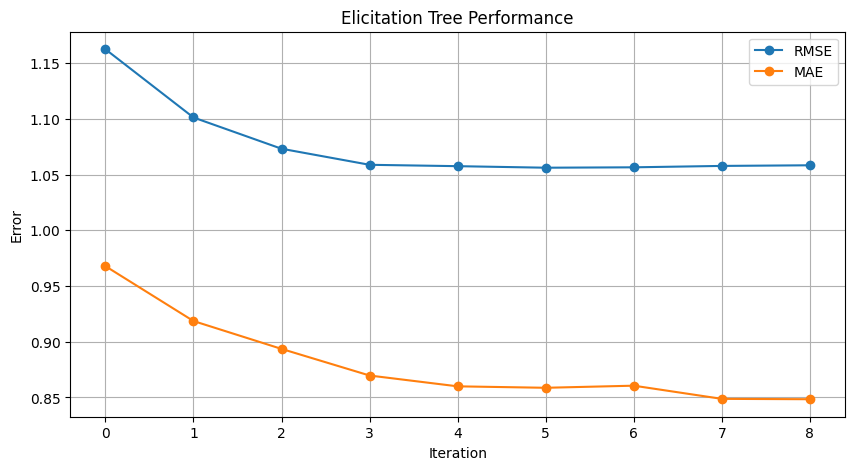

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(approach1_rmse)), approach1_rmse, label='RMSE', marker='o')
plt.plot(range(len(approach1_mae)), approach1_mae, label='MAE', marker='o')
plt.title('Elicitation Tree Performance')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.legend()
plt.grid()
plt.show()

# Approach 2

In [9]:
def elicitation_by_tree_path_retrain_depth(train, test, X, idx_to_rid, idx_to_cid, iteration=5):
    """
    Method 2 (final): Retrain tree each round, walk i steps based on train_copy ratings.
    Follow tree splits using 3-way logic (Lovers / Haters / Unknown).
    Ask the item at depth i if user reaches it.

    Parameters:
    - tree_model_class: class (not instance) of the tree model
    - train, test, X: lil_matrix
    - idx_to_rid, idx_to_cid: mapping of matrix index to raw ID
    - iteration: number of rounds

    Returns:
    - rmse_list, mae_list
    """

    num_users, num_items = train.shape
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    rmse_list, mae_list = [], []
    cid_to_idx = {v: k for k, v in idx_to_cid.items()}

    # Step 0: Baseline SVD
    train_df = matrix_to_df_2(train_copy, idx_to_rid, idx_to_cid)
    reader = Reader(rating_scale=(1, 5))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    trainset = data_r.build_full_trainset()
    algo = SVD()
    algo.fit(trainset)
    test_df = matrix_to_df_2(test, idx_to_rid, idx_to_cid)
    test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    testset = test_data.build_full_trainset().build_testset()
    predictions = algo.test(testset)
    rmse_list.append(accuracy.rmse(predictions, verbose=True))
    mae_list.append(accuracy.mae(predictions, verbose=True))
    print("✅ Baseline evaluation complete.")

    for i in range(iteration):
        print(f"\n🔁 Iteration {i+1}/{iteration} (train tree to depth {i+1})")

        # 1. Retrain tree with max_depth = i
        pct = Tree(max_depth=i+1, min_instances=7)  # You can adjust min_instances
        x_df = matrix_to_full_df(train_copy, idx_to_rid, idx_to_cid)
        pct.fit(x_df, x_df)

        print("🌳 Tree re-trained.")

        # 2. Walk tree and ask at depth i
        for u in range(num_users):
            node = pct.root
            depth = 0

            # Walk through tree using train_copy ratings
            while node and not node.is_leaf and node.attribute_name and depth < i:
                item = node.attribute_name
                if item not in cid_to_idx:
                    node = None
                    break
                item_idx = cid_to_idx[item]
                rating = train_copy[u, item_idx]

                if rating >= 4:
                    node = node.children[0]  # Lovers
                elif rating > 0:
                    node = node.children[1]  # Haters
                else:
                    node = node.children[2]  # Unknowns

                depth += 1

            # Ask item at depth i
            if node is None or node.attribute_name is None:
                continue

            item = node.attribute_name
            if item not in cid_to_idx:
                continue
            item_idx = cid_to_idx[item]
            rating = X_copy[u, item_idx]

            if rating > 0:
                train_copy[u, item_idx] = rating
                X_copy[u, item_idx] = 0  # Mark as asked

        # 3. Evaluate
        train_df = matrix_to_df_2(train_copy, idx_to_rid, idx_to_cid)
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        trainset = data_r.build_full_trainset()
        algo.fit(trainset)
        test_df = matrix_to_df_2(test, idx_to_rid, idx_to_cid)
        test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        testset = test_data.build_full_trainset().build_testset()
        predictions = algo.test(testset)
        rmse_list.append(accuracy.rmse(predictions, verbose=True))
        mae_list.append(accuracy.mae(predictions, verbose=True))
        print(f"✅ Iteration {i+1} complete.")

    return rmse_list, mae_list




In [10]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

approach2 = elicitation_by_tree_path_retrain_depth(train,test,X_matrix, idx_to_rid, idx_to_cid, iteration=8)


RMSE: 1.1612
MAE:  0.9668
✅ Baseline evaluation complete.

🔁 Iteration 1/8 (train tree to depth 1)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 1.1005
MAE:  0.9180
✅ Iteration 1 complete.

🔁 Iteration 2/8 (train tree to depth 2)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 1.0810
MAE:  0.9012
✅ Iteration 2 complete.

🔁 Iteration 3/8 (train tree to depth 3)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 1.0677
MAE:  0.8868
✅ Iteration 3 complete.

🔁 Iteration 4/8 (train tree to depth 4)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 1.0594
MAE:  0.8759
✅ Iteration 4 complete.

🔁 Iteration 5/8 (train tree to depth 5)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 1.0562
MAE:  0.8704
✅ Iteration 5 complete.

🔁 Iteration 6/8 (train tre

# Approach 3

In all iterations, we start from building a one-level tree. If the item is already asked for in one of the last iterations from the user, go to the next level. E.g.
In the first iteration, we build a one-level tree. Then only one item is selected by the tree and is added to the training set.  Prediction and RMSE are computed via SVD.
In the second iteration, we try to build a two-level tree and traverse each user from the root. The first unasked item for each user is added to the training set. Prediction and RMSE are computed via SVD.

- implementation

In each outer iteratiion, we retrain a tree with depth equal to the number of current iteration. 
Then we iteration all depth of the current tree and generate item_user_map for each node in each level. Item_user_map is a dictionary with item as key and list of user as value. For each node, we map item_user_map to path. Path is a dictionary with user as key and item as value. Then for each user, we look up item in his path one by one: If item is not in asked_items, we add it to asked_items and items_to_add. If the item is in asked_items, we skip this item and look for the next item. 


## Questions
what should we do if all items in the user's path has been asked in the previous iteration?

In [16]:
def elicitation_tree_3(train, test, X, iteration=8, rid_to_idx=None, cid_to_idx=None):
    rmse, mae = [], []
    
    # Initial training setup
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    all_users = range(train.shape[0])
    
    # Initial model training
    train_df = matrix_to_df_2(train_copy, idx_to_rid, idx_to_cid)
    reader = Reader(rating_scale=(1, 5))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    algo = SVD().fit(data_r.build_full_trainset())
    
    # Evaluate initial performance
    test_df = matrix_to_df_2(test, idx_to_rid, idx_to_cid)
    test_set = list(zip(test_df['user_id'], test_df['item_id'], test_df['rating']))
    predictions = algo.test(test_set)
    rmse.append(accuracy.rmse(predictions))
    mae.append(accuracy.mae(predictions))
    print(f"Initial RMSE: {rmse[-1]}, Initial MAE: {mae[-1]}")

    # Initialize asked items dictionary
    asked_items = {user_idx: set() for user_idx in all_users}

    # Main elicitation loop
    for current_depth in range(1, iteration+1):
        print(f"\n🚀 Building a {current_depth} depth tree")
        
        # 1. Build tree with current iteration depth
        current_train_df = matrix_to_full_df(train_copy, idx_to_rid, idx_to_cid)
        pct = Tree(max_depth=current_depth)
        pct.fit(current_train_df, current_train_df)
        # pct.print_tree_structure()
        
        # 2. Generate item_user_map for each level
        item_user_map = defaultdict(list)
        for level in range(current_depth):
            parent_nodes = pct.get_nodes_by_level(level)
            
            for node in parent_nodes:
                if node.is_leaf or not isinstance(node.attribute_name, int):
                    continue
                
                item_id = node.attribute_name
                item_idx = cid_to_idx[item_id]
                child_users = []
                
                # Collect users from all children
                for child in node.children:
                    if child and hasattr(child, 'user_ids') and len(child.user_ids) > 0:
                        user_indices = [rid_to_idx[int(u)] for u in child.user_ids if int(u) in rid_to_idx]
                        child_users.extend(user_indices)
                
                # Update item_user_map
                if item_idx not in item_user_map:
                    item_user_map[item_idx] = []
                item_user_map[item_idx].extend(child_users)

        # 3. Map item_user_map to path dictionary (user -> items)
        path = defaultdict(list)
        for item_idx, users in item_user_map.items():
            for user_idx in users:
                path[user_idx].append(item_idx)
        print(f"Path: {path}")
       

        # 4. Collect items to add
        items_to_add = defaultdict(list)
        for user_idx in all_users:
            if user_idx in path:
                for item_idx in path[user_idx]:
                    if item_idx not in asked_items[user_idx]:
                        asked_items[user_idx].add(item_idx)
                        items_to_add[user_idx].append(item_idx)
                        break  # Only add first unasked item
        # print all users and their items_to_add
        for user_idx, items in items_to_add.items():
            if len(items) > 0:
                print(f"User {user_idx} has items to add: {items}")
            else:
                print(f"User {user_idx} has no items to add")



        # 5. Update training data
        for user_idx, item_idx in items_to_add.items():
            train_copy[user_idx, item_idx] = X[user_idx, item_idx]
            X_copy[user_idx, item_idx] = 0

        # 6. Retrain and evaluate
        updated_train_df = matrix_to_df_2(train_copy, idx_to_rid, idx_to_cid)
        data_r = Dataset.load_from_df(updated_train_df[['user_id', 'item_id', 'rating']], reader)
        algo = SVD().fit(data_r.build_full_trainset())
        
        predictions = algo.test(test_set)
        rmse.append(accuracy.rmse(predictions))
        mae.append(accuracy.mae(predictions))

        # print users and item in asked_items and items_to_add together
    for user_idx, items in asked_items.items():
        print(f"User {user_idx} has asked items: {items}")    

    return rmse, mae


In [18]:
approach3 = elicitation_tree_3(train, test, X_matrix, iteration=8, rid_to_idx=rid_to_idx, cid_to_idx=cid_to_idx)
#approach3_rmse = approach3[0]
#approach3_mae = approach3[1]
#print("Approach 3 RMSE:", approach3_rmse)

RMSE: 1.1615
MAE:  0.9670
Initial RMSE: 1.16154567429877, Initial MAE: 0.9669687400793251

🚀 Building a 1 depth tree
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
Path: defaultdict(<class 'list'>, {1969: [268], 230: [268], 1414: [268], 1732: [268], 161: [268], 0: [268], 1: [268], 2: [268], 3: [268], 4: [268], 5: [268], 6: [268], 7: [268], 8: [268], 9: [268], 10: [268], 11: [268], 12: [268], 13: [268], 14: [268], 15: [268], 16: [268], 17: [268], 18: [268], 19: [268], 20: [268], 21: [268], 22: [268], 23: [268], 24: [268], 25: [268], 26: [268], 27: [268], 28: [268], 29: [268], 30: [268], 31: [268], 32: [268], 33: [268], 34: [268], 35: [268], 36: [268], 37: [268], 38: [268], 39: [268], 40: [268], 41: [268], 42: [268], 43: [268], 44: [268], 45: [268], 46: [268], 47: [268], 48: [268], 49: [268], 50: [268], 51: [268], 52: [268], 53: [268], 54: [268], 55: [268], 56: [268], 57: [268], 58: [268], 59: [268], 60: [268], 61: [268], 62: [268], 63: [268], 64: [268], 65: [26

In [37]:
item_idx = cid_to_idx[1380]
item_idx

525

In [38]:
user_indices = rid_to_idx[1172]
user_indices

526

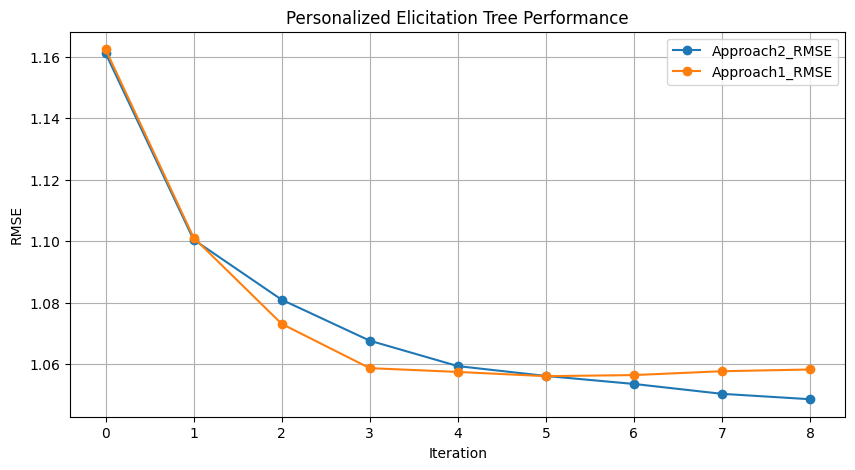

In [14]:
plt.figure(figsize=(10, 5))
# plt.plot(range(len(approach3[0])), approach3[0], label='Approach3_RMSE', marker='o')
plt.plot(range(len(approach2[0])), approach2[0], label='Approach2_RMSE', marker='o')
plt.plot(range(len(approach1[0])), approach1[0], label='Approach1_RMSE', marker='o')
plt.title('Personalized Elicitation Tree Performance')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()

# Non-personalized

In [ ]:
def i_variance(matirx):
    c = matrix.copy()
    c_2 = c.power(2)
    E_2 = c_2.mean(0)
    E = c.mean(0)
    v = E_2 - np.sqrt(E)
    return (np.asarray(v)).flatten()

def i_random(matirx):
    c = matrix.copy()
    c_2 = c.power(2)
    E_2 = c_2.mean(0)
    E = c.mean(0)
    v = E_2 - np.sqrt(E)
    return (np.asarray(v)).flatten()

def i_entropy(matirx):
    entropy = []
    for item in range(0, matirx.shape[1]):
        ratings = matirx.getcol(item).data
        count_r = Counter(ratings)
        len_rating = len(ratings)
        ent = 0
        for c in count_r:
            ent -= (count_r[c]/len_rating)*math.log(count_r[c]/len_rating)
        entropy.append(ent)
    return (np.asarray(entropy))

def i_entropy_0(matirx):
    entropy = []
    c_all = matirx.shape[0]
    for item in range(0, matirx.shape[1]):
        ratings = matirx.getcol(item).data
        count_r = Counter(ratings)
        count_r[0] = c_all - matirx.getcol(item).count_nonzero()
        ent = 0
        for c in count_r:
            ent -= (count_r[c]/c_all)*math.log(count_r[c]/c_all)
        entropy.append(ent)
    return (np.asarray(entropy))

def i_pop(matrix):
    popularity = []
    for item in range(0, matrix.shape[1]):
        popularity.append(matrix.getcol(item).count_nonzero())
        
    return (np.asarray(popularity))

def log_pop_entropy(matrix):
    entropy = i_entropy(matrix)
    popularity = i_pop(matrix)
    scores = np.log(popularity) *  entropy 
    return (np.asarray(scores))

def log_pop_entropy0(matrix):
    entropy = i_entropy_0(matrix)
    popularity = i_pop(matrix)
    scores = np.log(popularity) *  entropy 
    return (np.asarray(scores))

def sqrt_pop_variance(matrix):
    variance = i_variance(matrix)
    popularity = i_pop(matrix)
    scores = np.sqrt(popularity) *  variance 
    return (np.asarray(scores))

def helf(matrix):
    log_U = np.log(matrix.shape[0])
    lf = np.log(i_pop(matrix))/log_U
    h = i_entropy(matrix)/np.log(5)
    helf = (2* lf*h)/(lf+h)
    return helf

def helf0(matrix):
    log_U = np.log(matrix.shape[0])
    lf = np.log(i_pop(matrix))/log_U
    h = i_entropy_0(matrix)/np.log(5)
    helf = (2* lf*h)/(lf+h)
    return helf

def i_co_rate(matrix):
    matrix_c = matrix.copy()
    matrix_c[matrix_c != 0] = 1
    c= matrix_c.T.dot(matrix_c)
    c.setdiag(0, k=0)
    
    return np.asarray(c.sum(axis=0))[0]

In [ ]:
def elicitation_np(train,test,X,strategy,iteration,k,positive=False):
    rmse,mae = [],[]
    
    # Performance before elicitation
    train_df = matrix_to_df_2(train,idx_to_rid,idx_to_cid)
    reader = Reader(rating_scale=(1, 5))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    data_rr = data_r.build_full_trainset()
    algo = SVD()
    algo.fit(data_rr)
    test_df = matrix_to_df_2(test,idx_to_rid,idx_to_cid)
    test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    test_rr = test_r.build_full_trainset()
    predictions= algo.test(test_rr.build_testset())
    rmse.append(accuracy.rmse(predictions))
    mae.append(accuracy.mae(predictions))
    
    c_u_dict = {}
    all_items = list(range(0,train.shape[1]))
    X_copy = (X.tolil()).copy()
    
    train_copy = (train.tolil()).copy()

    #scores = strategy(train_copy)
    
    for count in range(0,iteration-1):
        scores = strategy(train_copy)
        if positive:
            ranking = np.argsort(-scores)
        else:
            ranking = np.argsort(scores)
        for u in range(0, train.shape[0]):
            if count ==0:
                p_u = train_copy.getrow(u).nonzero()[1]
                c_u = set_diff(all_items,p_u)
                c_u_dict[u] = c_u.copy()
            else:
                c_u = c_u_dict[u].copy()                
          
            ranking_u = ranking[np.in1d(ranking,c_u)]
            topk_u = ranking_u[:k]
            c_u_dict[u] = set_diff(c_u,topk_u)
            px_u = X_copy.getrow(u).nonzero()[1]
            recom = set_intersection(topk_u,px_u)
            for item in recom:                  
                train_copy[u,item] = X[u,item]
                X_copy[u,item] = 0
        train_df = matrix_to_df_2(train_copy,idx_to_rid,idx_to_cid)

        reader = Reader(rating_scale=(1, 5))
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        data_rr = data_r.build_full_trainset()
        algo.fit(data_rr)
        test_df = matrix_to_df(test,idx_to_rid,idx_to_cid)
        test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        test_rr = test_r.build_full_trainset()
        predictions= algo.test(test_rr.build_testset())
        rmse.append(accuracy.rmse(predictions))
        mae.append(accuracy.mae(predictions))
        
        print(count+1)
    return rmse,mae

# Approach 4

In [ ]:
def elicitation_tree(train, test, X, iteration=8, rid_to_idx=None, cid_to_idx=None):
    rmse, mae = [], []
    
    # Initial training setup
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    all_users = range(train.shape[0])
    
    # Initial model training
    train_df = matrix_to_df_2(train_copy, idx_to_rid, idx_to_cid)

    # Initialize asked items dictionary
    asked_items = {user_idx: set() for user_idx in all_users}
    final_tree = None

    # Main elicitation loop
    for current_depth in range(1, iteration+1):
        print(f"\n🚀 Building a {current_depth} depth tree")
        
        # 1. Build tree with current iteration depth
        current_train_df = matrix_to_full_df(train_copy, idx_to_rid, idx_to_cid)
        pct = Tree(max_depth=current_depth)
        pct.fit(current_train_df, current_train_df)
        final_tree = pct # Store the final tree for later use
        # print final tree is built at depth
        print(f"Final tree built at depth {current_depth}")
        
        
        # 2. Generate item_user_map for each level
        item_user_map = defaultdict(list)
        for level in range(current_depth):
            parent_nodes = pct.get_nodes_by_level(level)
            
            for node in parent_nodes:
                if node.is_leaf or not isinstance(node.attribute_name, int):
                    continue
                
                item_id = node.attribute_name
                item_idx = cid_to_idx[item_id]
                child_users = []
                
                # Collect users from all children
                for child in node.children:
                    if child and hasattr(child, 'user_ids') and len(child.user_ids) > 0:
                        user_indices = [rid_to_idx[int(u)] for u in child.user_ids if int(u) in rid_to_idx]
                        child_users.extend(user_indices)
                
                # Update item_user_map
                # if item_idx not in item_user_map:
                #    item_user_map[item_idx] = []
                item_user_map[item_idx].extend(child_users)

        # 3. Map item_user_map to path dictionary (user -> items)
        path = defaultdict(list)
        for item_idx, users in item_user_map.items():
            for user_idx in users:
                path[user_idx].append(item_idx)
        print(f"Path: {path}")
       

        # 4. Collect items to add
        items_to_add = defaultdict(list)
        for user_idx in all_users:
            if user_idx in path:
                for item_idx in path[user_idx]:
                    if item_idx not in asked_items[user_idx]:
                        asked_items[user_idx].add(item_idx)
                        items_to_add[user_idx].append(item_idx)
                        break  # Only add first unasked item
        # print all users and their items_to_add
        # for user_idx, items in items_to_add.items():
        #     if len(items) > 0:
        #         print(f"User {user_idx} has items to add: {items}")
        #     else:
        #         print(f"User {user_idx} has no items to add")



        # 5. Update training data
        for user_idx, item_idx in items_to_add.items():
            train_copy[user_idx, item_idx] = X[user_idx, item_idx]
            X_copy[user_idx, item_idx] = 0

        # 6. Retrain and evaluate
        updated_train_df = matrix_to_df_2(train_copy, idx_to_rid, idx_to_cid)


    return final_tree, updated_train_df, train_copy


In [ ]:
approach4 = elicitation_tree(train, test, X_matrix, iteration=6, rid_to_idx=rid_to_idx, cid_to_idx=cid_to_idx)

In [18]:
approach4_tree = approach4[0]
approach4_tree.print_tree_structure()

Leaf Node: No
Depth: 0
Item_ID: 32
user_ids: [2, 5, 8, 9, 10, 11, 13, 15, 17, 18, 19, 22, 23, 24, 26, 28, 29, 31, 33, 34, 35, 36, 42, 44, 45, 48, 49, 53, 58, 59, 62, 65, 73, 75, 78, 82, 90, 92, 93, 97, 101, 102, 103, 107, 117, 118, 119, 123, 127, 129, 130, 131, 133, 134, 136, 137, 139, 146, 147, 148, 149, 150, 151, 156, 157, 161, 162, 163, 166, 169, 173, 175, 178, 179, 181, 186, 187, 190, 192, 193, 195, 198, 199, 202, 203, 204, 205, 208, 210, 212, 214, 216, 220, 223, 224, 225, 229, 230, 235, 237, 238, 240, 242, 245, 249, 255, 258, 259, 260, 261, 262, 264, 267, 268, 270, 271, 272, 273, 274, 278, 284, 285, 287, 293, 295, 300, 301, 302, 303, 305, 306, 307, 308, 309, 310, 314, 319, 321, 323, 326, 327, 329, 331, 333, 335, 336, 337, 338, 339, 340, 342, 343, 346, 349, 351, 352, 355, 366, 368, 372, 376, 377, 380, 385, 386, 390, 392, 396, 398, 402, 403, 406, 408, 409, 411, 412, 415, 419, 424, 425, 426, 429, 435, 436, 438, 442, 444, 445, 451, 452, 453, 454, 456, 457, 461, 462, 463, 466, 471, 474

In [127]:
updated_train_df = approach4[1]
updated_train_df

,user_id,item_id,rating
0,2,780,3.0
1,5,515,4.0
2,5,608,4.0
3,5,2952,2.0
4,5,32,4.0
...,...,...,...
8759,2,1598,0.0
8760,2,1972,0.0
8761,2,2095,0.0
8762,2,3445,0.0


In [191]:
# print number of unique user IDs in updated_train_df
unique_user_ids = updated_train_df['user_id'].nunique()
print(f"Number of unique user IDs in updated_train_df: {unique_user_ids}")


Number of unique user IDs in updated_train_df: 2810


we iterate each item and each node with children as leaf
for each item we calculate a score, which is the average rating of all users who rated that item in that node.
then we rank the score. Top k score would be picked for recommendation


When building the tree, we set the min_instance, which is the minimum amount of users in a node. Therefore, a leaf node might occur at any depth of the tree. We want to create a leaf_item_user_map with item id as key and list of user id as value. item id comes from the parent node of a leaf node. user id are id of all users in that leaf node.

### ID version create_leaf_item_user_map

In [150]:
def create_leaf_item_user_map(final_tree):
    """Collect item-user mappings from leaf node parents using original IDs"""
    leaf_item_user_map = defaultdict(list)
    
    # Traverse all non-leaf nodes using BFS
    queue = [final_tree.root]
    while queue:
        current_node = queue.pop(0)
        
        if current_node.is_leaf:
            continue
            
        if isinstance(current_node.attribute_name, int):
            parent_item_id = current_node.attribute_name
            
            # Track child index for grouping
            for child_idx, child in enumerate(current_node.children):
                if child and child.is_leaf:
                    # Create unique group identifier using parent + child index
                    group_key = (parent_item_id, child_idx)
                    
                    # Convert and store user IDs for this specific leaf child
                    leaf_item_user_map[group_key].extend(
                        [int(u) for u in child.user_ids]
                    )
        
        # Continue traversal
        queue.extend(current_node.children)
    
    return leaf_item_user_map


In [ ]:
# print the leaf_item_user_map
leaf_item_user_map = create_leaf_item_user_map(approach4_tree)
print("Leaf Item-User Map:")
for group_key, users in leaf_item_user_map.items():
    print(f"Item ID: {group_key}, Number of Users: {len(users)}, User Id: {users}")
    # print total number of users in all groups
   

Leaf Item-User Map:
Item ID: (2371, 1), Number of Users: 5, User Id: [3491, 1958, 5090, 3308, 5880]
Item ID: (2948, 0), Number of Users: 2, User Id: [3626, 4879]
Item ID: (2948, 1), Number of Users: 3, User Id: [5054, 4957, 1150]
Item ID: (1291, 1), Number of Users: 4, User Id: [3778, 5763, 4682, 2105]
Item ID: (913, 0), Number of Users: 2, User Id: [4042, 1181]
Item ID: (913, 1), Number of Users: 3, User Id: [1447, 587, 3411]
Item ID: (913, 2), Number of Users: 6, User Id: [2063, 4626, 3280, 855, 3808, 4041]
Item ID: (260, 1), Number of Users: 2, User Id: [1758, 1335]
Item ID: (1293, 1), Number of Users: 4, User Id: [2820, 6040, 3118, 352]
Item ID: (1206, 0), Number of Users: 0, User Id: []
Item ID: (1206, 1), Number of Users: 1, User Id: [3311]
Item ID: (431, 0), Number of Users: 3, User Id: [1285, 2380, 4312]
Item ID: (431, 1), Number of Users: 6, User Id: [3683, 3526, 2453, 1050, 5627, 1340]
Item ID: (2273, 0), Number of Users: 13, User Id: [4808, 4725, 2857, 3312, 3859, 3993, 5376

In [192]:
print(f"Total number of users in all groups: {sum(len(users) for users in leaf_item_user_map.values())}")
# print total of groups
print(f"Total number of groups: {len(leaf_item_user_map)}")

Total number of users in all groups: 2828
Total number of groups: 283


In [193]:
# I want to know which user is in lead_item_user_map but not in updated_train_df
# Convert updated_train_df to a set of user IDs
updated_user_ids = set(updated_train_df['user_id'].unique())
# Convert leaf_item_user_map to a set of user IDs
leaf_user_ids = set()
for users in leaf_item_user_map.values():
    leaf_user_ids.update(users)
# Find the difference
missing_users = leaf_user_ids - updated_user_ids
print(f"Missing users in updated_train_df: {missing_users}")
# print the number of missing users
print(f"Number of missing users in updated_train_df: {len(missing_users)}")


Missing users in updated_train_df: {4291, 5446, 2952, 5641, 2859, 4269, 2814, 4830, 305, 1457, 918, 4342, 2744, 377, 764, 5272, 926, 1887}
Number of missing users in updated_train_df: 18


We loop over all groups ((parent_item_id, child_idx)), and in each group, we look up each item in the train_df.  For each item that an user hasn't rated, find the ratings of this item from all other users in the same node and calculate the average. we pick the top k.

In [173]:
def generate_user_recommendations(leaf_item_user_map, updated_train_df, rid_to_idx, cid_to_idx, idx_to_cid, top_k=5):
    """
    Generates recommendations using original IDs throughout
    """
    # Convert DataFrame to sparse matrix with current mappings
    train_matrix, _, _, _, _ = df_to_matrix(
        updated_train_df, 
        row_name='user_id', 
        col_name='item_id', 
        value='rating'
    )
    
    # Convert to LIL format for efficient access
    train_lil = train_matrix.tolil()
    
    # Create user->rated_items mapping with original IDs
    user_rated_items = updated_train_df.groupby('user_id')['item_id'].apply(set).to_dict()
    
    user_recommendations = {}

    for (parent_item_id, child_idx), user_ids in leaf_item_user_map.items():
        # Convert user IDs to matrix indices
        valid_user_indices = [
            rid_to_idx[uid] 
            for uid in user_ids 
            if uid in rid_to_idx and rid_to_idx[uid] < train_lil.shape[0]
        ]
        
        if not valid_user_indices:
            continue

        # Calculate average ratings using original item IDs
        item_scores = {}
        for item_id in updated_train_df['item_id'].unique():
            item_idx = cid_to_idx[item_id]
            # Convert indices to numpy array for proper slicing
            user_indices_np = np.array(valid_user_indices, dtype=int)
            # Get ratings using numpy array indices
            rating_data = train_lil[user_indices_np, item_idx].data
            # Handle empty ratings case
            item_scores[item_id] = np.mean(rating_data) if len(rating_data) > 0 else 0
           

        # Generate recommendations for each user
        for uid in user_ids:
            if uid not in rid_to_idx:
                continue  # Skip users not in current matrix
                
            # Filter out already rated items
            items_to_exclude = set(user_rated_items.get(uid, set()))
            filtered_recs = {
                item: score 
                for item, score in item_scores.items() 
                if item not in items_to_exclude and score > 0
            }
            
            # Sort and store top K
            sorted_items = sorted(filtered_recs.items(), key=lambda x: -x[1])[:top_k]
            user_recommendations[uid] = dict(sorted_items)

    return user_recommendations


In [187]:
def generate_user_recommendations(leaf_item_user_map, updated_train_df, rid_to_idx, cid_to_idx, idx_to_cid, top_k=5):
    """
    Generates personalized recommendations using group-based collaborative filtering
    with original user/item IDs and proper index validation
    """
    # Convert DataFrame to sparse matrix with current mappings
    train_matrix, _, _, _, _ = df_to_matrix(
        updated_train_df, 
        row_name='user_id', 
        col_name='item_id', 
        value='rating'
    )
    
    # Convert to CSR format for efficient slicing
    train_csr = train_matrix.tocsr()
    num_users, num_items = train_csr.shape
    
    # Create user->rated_items mapping with original IDs
    user_rated_items = updated_train_df.groupby('user_id')['item_id'].apply(set).to_dict()
    
    user_recommendations = {}

    for (parent_item_id, child_idx), user_ids in leaf_item_user_map.items():
        # Convert to valid matrix indices and filter out-of-bounds users
        valid_user_indices = [
            rid_to_idx[uid] 
            for uid in user_ids 
            if uid in rid_to_idx and rid_to_idx[uid] < num_users
        ]
        
        if not valid_user_indices:
            continue

        # Calculate average ratings for all items using group users
        item_scores = {}
        for item_id in updated_train_df['item_id'].unique():
            if item_id not in cid_to_idx:
                continue  # Skip new items not in training data
                
            item_idx = cid_to_idx[item_id]
            ratings = train_csr[valid_user_indices, item_idx].data
            
            if ratings.size > 0:
                item_scores[item_id] = np.mean(ratings)
            else:
                item_scores[item_id] = 0  # Fallback for unrated items

        # Generate personalized recommendations for each user
        for uid in user_ids:
            if uid not in rid_to_idx:
                continue  # Skip users not in current matrix
                
            # Get items to exclude (already rated by this user)
            excluded_items = set(user_rated_items.get(uid, set()))
            
            # Filter and sort recommendations
            filtered_recs = {
                item: score 
                for item, score in item_scores.items()
                if item not in excluded_items and score > 0
            }
            
            sorted_items = sorted(filtered_recs.items(), key=lambda x: -x[1])[:top_k]
            user_recommendations[uid] = dict(sorted_items)

    return user_recommendations


In [188]:
# Generate recommendations for each group
user_recommendations = generate_user_recommendations(leaf_item_user_map, updated_train_df, rid_to_idx, cid_to_idx, idx_to_cid, top_k=1)

print("User Recommendations:")
for user_id, recs in user_recommendations.items():
    print(f"User ID: {user_id}, Recommendations: {recs}")

User Recommendations:
User ID: 3491, Recommendations: {2115: 5.0}
User ID: 1958, Recommendations: {2115: 5.0}
User ID: 5090, Recommendations: {2115: 5.0}
User ID: 3308, Recommendations: {2115: 5.0}
User ID: 5880, Recommendations: {2115: 5.0}
User ID: 3626, Recommendations: {2881: 5.0}
User ID: 4879, Recommendations: {2881: 5.0}
User ID: 5054, Recommendations: {2442: 5.0}
User ID: 4957, Recommendations: {2442: 5.0}
User ID: 1150, Recommendations: {2442: 5.0}
User ID: 3778, Recommendations: {1372: 5.0}
User ID: 5763, Recommendations: {1372: 5.0}
User ID: 4682, Recommendations: {1372: 5.0}
User ID: 2105, Recommendations: {1372: 5.0}
User ID: 4042, Recommendations: {1687: 4.0}
User ID: 1181, Recommendations: {1687: 4.0}
User ID: 1447, Recommendations: {3148: 5.0}
User ID: 587, Recommendations: {3148: 5.0}
User ID: 3411, Recommendations: {3148: 5.0}
User ID: 2063, Recommendations: {1217: 5.0}
User ID: 4626, Recommendations: {1217: 5.0}
User ID: 3280, Recommendations: {1217: 5.0}
User ID: 85

In [185]:
# Flatten the dictionary into a list of tuples
rows = [
    {'user_id': user_id, 'item_id': item_id, 'score': score}
    for user_id, recs in user_recommendations.items()
    for item_id, score in recs.items()
]

# Create the DataFrame
prediction = pd.DataFrame(rows, columns=['user_id', 'item_id', 'score'])
prediction

,user_id,item_id,score
0,3491,2115,5.0
1,1958,2115,5.0
2,5090,2115,5.0
3,3308,2115,5.0
4,5880,2115,5.0
...,...,...,...
2821,5998,1393,5.0
2822,6010,1393,5.0
2823,6011,1393,5.0
2824,6014,1393,5.0


In [178]:
test_df = matrix_to_df_2(test, idx_to_rid, idx_to_cid)
test_df = test_df[['user_id', 'item_id', 'rating']]
test_df

,user_id,item_id,rating
0,2,1537,4.0
1,2,647,3.0
2,2,648,4.0
3,2,2916,3.0
4,2,1687,3.0
...,...,...,...
84835,6040,1663,2.0
84836,6040,3111,5.0
84837,6040,290,4.0
84838,6040,2147,2.0


In [186]:
from sklearn.metrics import mean_squared_error
def calculate_rmse(prediction_df, test_df):
    """
    Calculate RMSE between predicted scores and actual ratings
    
    Args:
        prediction_df: DataFrame with columns ['user_id', 'item_id', 'score']
        test_df: DataFrame with columns ['user_id', 'item_id', 'rating']
    
    Returns:
        float: RMSE value
    """
    # Merge predictions with test ratings
    merged_df = pd.merge(
        test_df,
        prediction_df,
        on=['user_id', 'item_id'],
        how='inner',
        suffixes=('_true', '_pred')
    )
    
    # Calculate RMSE using numpy/scikit-learn
    rmse = np.sqrt(mean_squared_error(
        merged_df['rating'], 
        merged_df['score']
    ))
    
    return rmse

# Usage example
rmse_value = calculate_rmse(prediction, test_df)
print(f"RMSE: {rmse_value:.4f}")


RMSE: 1.5687


In [ ]:
def create_leaf_item_user_map_idx(final_tree, rid_to_idx, cid_to_idx):
    """Collect item-user mappings from leaf node parents using original IDs"""
    leaf_item_user_map = defaultdict(list)
    
    # Traverse all non-leaf nodes using BFS
    queue = [final_tree.root]
    while queue:
        current_node = queue.pop(0)
        
        if current_node.is_leaf:
            continue
            
        if isinstance(current_node.attribute_name, int):
            parent_item_id = current_node.attribute_name
            parent_item_idx = cid_to_idx[parent_item_id]
            
            # Track child index for grouping
            for child_idx, child in enumerate(current_node.children):
                if child and child.is_leaf:
                    # Create unique group identifier using parent + child index
                    group_key = (parent_item_idx, child_idx)
                    
                    # Convert and store user IDs for this specific leaf child
                    leaf_item_user_map[group_key].extend(
                        [rid_to_idx[int(u)] for u in child.user_ids if int(u) in rid_to_idx]
                    )
        
        # Continue traversal
        queue.extend(current_node.children)
    
    return leaf_item_user_map


In [ ]:
def generate_group_recommendations(leaf_item_user_map, updated_train_df, top_k=1):
    """
    Generates recommendations for each leaf node group using original IDs
    """
    # Convert DataFrame to sparse matrix and get mappings
    train_matrix, rid_to_idx, idx_to_rid, cid_to_idx, idx_to_cid = df_to_matrix(
        updated_train_df, 
        row_name='user_id', 
        col_name='item_id', 
        value='rating'
    )
    
    # Convert to LIL format for efficient row operations
    train_matrix_lil = train_matrix.tolil()
    
    group_recommendations = {}

    for group_key, user_indices in leaf_item_user_map.items():
        parent_item_idx, child_idx = group_key
        
        # Skip groups with 0 users
        if len(user_indices) == 0:
            continue

        item_scores = {}
        
        # Calculate scores for all items in the matrix
        for item_idx in [cid_to_idx[item_id] for item_id in updated_train_df['item_id'].tolist()]:
            # Get ratings from group users for current item
            ratings = [train_matrix_lil[user_idx, item_idx] for user_idx in user_indices]
            
            if ratings:
                item_scores[item_idx] = np.mean(ratings)
            else:
                # Set score to 0 if no ratings in group
                item_scores[item_idx] = 0

        # Convert indices to original IDs and filter zero scores
        scored_items = {
            idx_to_cid[idx]: score
            for idx, score in item_scores.items()
            if score > 0  # Exclude items with zero score
        }
        
        # Sort and store top K recommendations
        sorted_items = sorted(scored_items.items(), key=lambda x: -x[1])[:top_k]
        group_recommendations[group_key] = dict(sorted_items)

    return group_recommendations
